# Variational Auto Encoder for MNIST with TFP Probabilistic Layers

이름: 최정우

학번: M2018076

Colab link: http://bit.ly/2P4ZRuk

---

MNIST 데이터셋을 이용해 variational autoencoder (VAE) 기반 generative model을 구축한다. (* 단, 데이터의 representation z에 대한 확률분포 p(z)가 다차원 normal distribution을 따른다고 가정함)

다음을 확인하는 리포트를 Colab 노트북을 이용해 작성한다. 

- 학습을 마친 VAE에 대해, MNIST 데이터셋의 representation p(z)가 다차원 normal distribution을 따르는지 확인한다.

- VAE의 encoder를 거쳐 나온 representation z를 ground truth(GT) label 별로 다른색을 주어 z의 분포를 가시화 한다.

- z의 분포를 보고 encoder가 label 별로 discriminative한 representation을 만들어내는지 여부를 확인한다. 만일 discriminative하지 않다면, VAE가 discriminative한 representation z를 학습하도록 수정한다.

- 학습을 마친 VAE의 decoder만으로 generative model을 구성한다. 이 때, p(z)에서 샘플링한 z 값을 decoder으로 주었을 때 손글씨 숫자 이미지가 만들어지는지 확인한다. 의미있게 만들어진 이미지는 어떤 특징을 가지고 있는지 논의한다.

## 목차

1. Dependencies & Prerequisites
2. MNIST 데이터셋 불러오기
3. Autoencoder 네트워크 구성
4. Variational Autoencoder
5. 학습 결과 분석

## 1. Dependencies & Prerequisites


###Install Prerequisites

Tensorflow probability를 사용하기위해서는 nightly 버전의 tensorflow를 설치해야한다.

Weight를 저장 및 불러오기에 사용하기위해 PyDrive 를 설치한다.

In [1]:
!pip3 install -q --upgrade tf-nightly-gpu-2.0-preview
!pip3 install -q tfp-nightly
!pip3 install h5py pyyaml 
!pip install -U -q PyDrive

import tensorflow as tf
import tensorflow_probability as tfp

print("tf version:", tf.__version__)
print("tfp version:", tfp.__version__)

    100% |████████████████████████████████| 345.1MB 60kB/s 
    100% |████████████████████████████████| 358kB 12.6MB/s 
    100% |████████████████████████████████| 61kB 21.8MB/s 
    100% |████████████████████████████████| 3.0MB 6.5MB/s 
    100% |████████████████████████████████| 931kB 15.7MB/s 
    100% |████████████████████████████████| 993kB 19.9MB/s 
tf version: 2.0.0-dev20190411
tfp version: 0.7.0-dev


###Import

사용할 라이브러리를 import 하고, 자주사용되는 라이브러리는 약칭으로 지정한다.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfpd = tfp.distributions


###구글 드라이브 연결
Colab의 현재 세션과 구글 드라이브를 연결하기 위해서 사용한다.

Weight를 저장하거나 저장된 weight를 불러오는데 필요하다.

사용방법: 코드 실행시 오른쪽 GDrive_Auth 아래에 생성되는 링크를 타고 구글 로그인을 한뒤에 권한을 수락하고 보이는 코드를 복사하여 링크 아래의 사각형에 붙여넣은 후 엔터를 친다.

In [0]:
#@title GDrive_Auth { vertical-output: true, display-mode: "both" }

# Colab의 현재 세션과 구글 드라이브를 연결하기 위해서 사용한다.
# weight를 저장하거나 불러오는데 필요하다.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## 2. MNIST 데이터셋 불러오기

텐서플로우에서 제공되는 Datasets iterator를 이용하여 데이터를 불러온다.

Early stopping 과 공정한 평가를 하기위해 주어진 트레이닝 셋을 8:2로 나누어 Validation dataset 을 생성한다.

Training dataset 과 Validation dataset 만으로 학습시킨다.

학습된 네트워크를 실험할 때는 Test dataset 을 이용하여 실험을 진행한다.

데이터값이 0~1사이 값을 가지도록 정규화하고 Data augmentation으로 Random binarize 를 진행한다.

In [4]:
# MNIST data from tensorflow_datasets
eval_split = tfds.Split.TRAIN.subsplit(tfds.percent[:20])
train_split = tfds.Split.TRAIN.subsplit(tfds.percent[20:])

eval_datasets = tfds.load(name='mnist',
                          split=eval_split,
                          as_supervised=False)
train_datasets = tfds.load(name='mnist',
                          split=train_split,
                          as_supervised=False)
test_datasets = tfds.load(name='mnist',
                          split=tfds.Split.TEST,
                          as_supervised=False)

# 정규화 및 랜덤 이진화
def _preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
  return image, image

def _test_preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  
  return image, sample['label']

# Dataset 전처리 및 배치화
train_dataset = (train_datasets
                 .map(_preprocess)
                 .batch(256)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))

eval_dataset = (eval_datasets
                .map(_preprocess)
                .batch(256)
                .prefetch(tf.data.experimental.AUTOTUNE))

test_dataset = (test_datasets
                .map(_test_preprocess)
                .batch(10000)
                .prefetch(tf.data.experimental.AUTOTUNE))

W0412 00:48:13.308083 139862064334720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:325: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/1.0.0. Subsequent calls will reuse this data.


##3. Variational Autoencoder



### 네트워크 구성

Variational Autoencoder 는 Autoencoder 와 마찬가지로 인코더네트워크와 디코더네트워크로 구성되어있다. 인코더 네트워크는 2D convolution 네트워크를 이용하여 정규분포를 가지도록 Latent variable z 의 확률분포를 생성하고, 디코더 네트워크는 2D transpose convolution 네트워크를 이용하여  Latent variable z 의 확률분포로 부터 샘플된 z를 입력 값과 유사하도록 복원 한다.


In [0]:
class VAE(tf.keras.Model):
    def __init__(self, encoded_size, base_depth):
        super(VAE, self).__init__()
        
        self.encoded_size = encoded_size
        self.base_depth = base_depth
        
        self.prior = tfpd.Independent(tfpd.Normal(loc=tf.zeros(self.encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)
        
        self.encoder = tfk.Sequential([
            tfkl.InputLayer(input_shape=(28, 28, 1)),
            tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
            tfkl.Conv2D(self.base_depth, 5, strides=1,
                        padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(self.base_depth, 5, strides=2,
                        padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(2 * self.base_depth, 5, strides=1,
                        padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(2 * self.base_depth, 5, strides=2,
                        padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                        padding='valid', activation=tf.nn.leaky_relu),
            tfkl.Flatten(),
            tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
                       activation=None),
            tfpl.MultivariateNormalTriL(
                encoded_size,
                activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior)),
        ])
        

        self.decoder = tfk.Sequential([
            tfkl.InputLayer(input_shape=[encoded_size]),
            tfkl.Reshape([1, 1, encoded_size]),
            tfkl.Conv2DTranspose(2 * self.base_depth, 7, strides=1,
                                 padding='valid', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(2 * self.base_depth, 5, strides=1,
                                 padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(2 * self.base_depth, 5, strides=2,
                                 padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(self.base_depth, 5, strides=1,
                                 padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(self.base_depth, 5, strides=2,
                                 padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(self.base_depth, 5, strides=1,
                                 padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                        padding='same', activation=None),
            tfkl.Flatten(),
            tfpl.IndependentBernoulli((28, 28, 1), tfpd.Bernoulli.logits),
        ])
        
    def call(self, inputs):
        return self.decoder(self.encoder(inputs))

### 네트워크 훈련 (실행 X)

Convolutional layer의 기준 filter 개수와 Latent variable z의 크기를 변경 시키며 훈련시킨다.
총 50회의 epoch 에서 연속적으로 2회의 loss에 개선이 없으면 earlystopping으로 훈련을 멈춘다.
Session time 때문에 훈련이 한번에 진행되지 않아서 여러번 나누어 학습시켰다.
훈련을 할 것이 아니기때문에 실행시키지 않는다.
다음 cell 에서 네트워크와 훈련시킨 웨이트를 불러와 분석을 진행한다.
총 훈련을 latent_size를 2부터 12까지 진행하였고, Convolution layer 의 base filter 갯수는 16, 32, 64 개로 변화시키며 훈련시켰다.

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
import glob

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto') # 조기종료 콜백함수 정의

recon = lambda x, rv_x: -rv_x.log_prob(x)

network = []

# 16 32 64 - 2~12
for base_depth in [16,32,64]:
    for encoded_size in range(2,13):
           
        network.append(VAE(encoded_size, base_depth))
        network[-1].compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                            loss=recon)
        network[-1].fit(train_dataset,
                        epochs=50,
                        validation_data=eval_dataset,
                        callbacks = [early_stopping])
        network[-1].summary()
        checkpoint_name = 'D'+str(base_depth)+"_L"+str(encoded_size)
        network[-1].save_weights(checkpoint_name)
        
        # Google auth refresh
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)
        
        # Upload weights
        for f in glob.glob(checkpoint_name+"*"):
            print("Upload file:",f)
            # Upload model
            model_file = drive.CreateFile({'title' : f})
            model_file.SetContentFile(f)
            model_file.Upload()

Epoch 1/50
188/188 [==============================] - 59s 315ms/step - loss: 223.9579 - val_loss: 0.0000e+00
Epoch 2/50
188/188 [==============================] - 50s 263ms/step - loss: 164.6661 - val_loss: 157.7719
Epoch 3/50
188/188 [==============================] - 50s 265ms/step - loss: 153.2638 - val_loss: 148.2284
Epoch 4/50
188/188 [==============================] - 50s 263ms/step - loss: 145.9760 - val_loss: 143.2938
Epoch 5/50
188/188 [==============================] - 50s 264ms/step - loss: 142.8858 - val_loss: 141.3980
Epoch 6/50
188/188 [==============================] - 50s 264ms/step - loss: 141.0123 - val_loss: 140.0729
Epoch 7/50
188/188 [==============================] - 50s 265ms/step - loss: 139.5947 - val_loss: 139.5797
Epoch 8/50
188/188 [==============================] - 50s 267ms/step - loss: 138.6350 - val_loss: 137.6903
Epoch 9/50
188/188 [==============================] - 50s 265ms/step - loss: 137.6410 - val_loss: 136.9689
Epoch 10/50
188/188 [==============

W0410 14:28:33.481761 140626223044480 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D32_L4.index
Upload file: D32_L4.data-00002-of-00003
Upload file: D32_L4.data-00000-of-00003
Upload file: D32_L4.data-00001-of-00003
Epoch 1/50
188/188 [==============================] - 54s 289ms/step - loss: 220.9497 - val_loss: 0.0000e+00
Epoch 2/50
188/188 [==============================] - 49s 260ms/step - loss: 160.9345 - val_loss: 152.3438
Epoch 3/50
188/188 [==============================] - 49s 259ms/step - loss: 148.1537 - val_loss: 145.0624
Epoch 4/50
188/188 [==============================] - 48s 255ms/step - loss: 142.1644 - val_loss: 138.8064
Epoch 5/50
188/188 [==============================] - 48s 257ms/step - loss: 137.6829 - val_loss: 135.1908
Epoch 6/50
188/188 [==============================] - 49s 259ms/step - loss: 134.9376 - val_loss: 133.4861
Epoch 7/50
188/188 [==============================] - 49s 260ms/step - loss: 133.4651 - val_loss: 131.9394
Epoch 8/50
188/188 [==============================] - 49s 259ms/step - loss: 132.1008 - val_loss: 131.1

W0410 14:47:41.805291 140626223044480 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Upload file: D32_L5.index
Upload file: D32_L5.data-00000-of-00003
Upload file: D32_L5.data-00002-of-00003
Upload file: D32_L5.data-00001-of-00003
Epoch 1/50
188/188 [==============================] - 56s 298ms/step - loss: 225.1032 - val_loss: 0.0000e+00
Epoch 2/50
188/188 [==============================] - 49s 262ms/step - loss: 157.0060 - val_loss: 148.8619
Epoch 3/50
188/188 [==============================] - 50s 265ms/step - loss: 146.6014 - val_loss: 143.5629
Epoch 4/50
188/188 [==============================] - 49s 261ms/step - loss: 140.6206 - val_loss: 138.0384
Epoch 5/50
188/188 [==============================] - 49s 263ms/step - loss: 137.3428 - val_loss: 135.7675
Epoch 6/50
188/188 [==============================] - 49s 260ms/step - loss: 134.2660 - val_loss: 131.1787
Epoch 7/50
188/188 [==============================] - 50s 264ms/step - loss: 130.8000 - val_loss: 128.8665
Epoch 8/50
188/188 [==============================] - 49s 261ms/step - loss: 128.7392 - val_loss: 127.8

W0410 15:11:35.732387 140626223044480 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Model: "vae_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 6)                 256155    
_________________________________________________________________
sequential_7 (Sequential)    (None, 28, 28, 1)         327105    
Total params: 583,260
Trainable params: 583,260
Non-trainable params: 0
_________________________________________________________________
Upload file: D32_L6.data-00002-of-00003
Upload file: D32_L6.data-00000-of-00003
Upload file: D32_L6.index
Upload file: D32_L6.data-00001-of-00003
Epoch 1/50
188/188 [==============================] - 55s 293ms/step - loss: 227.3153 - val_loss: 0.0000e+00
Epoch 2/50
188/188 [==============================] - 49s 259ms/step - loss: 160.9616 - val_loss: 151.1672
Epoch 3/50
188/188 [==============================] - 49s 259ms/step - loss: 148.7656 - val_loss: 145.1457
Epoch 4/50
188/188 [============================

W0410 15:33:56.945902 140626223044480 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Model: "vae_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 7)                 269043    
_________________________________________________________________
sequential_9 (Sequential)    (None, 28, 28, 1)         330241    
Total params: 599,284
Trainable params: 599,284
Non-trainable params: 0
_________________________________________________________________
Upload file: D32_L7.data-00000-of-00003
Upload file: D32_L7.data-00001-of-00003
Upload file: D32_L7.data-00002-of-00003
Upload file: D32_L7.index
Epoch 1/50
188/188 [==============================] - 55s 291ms/step - loss: 211.1003 - val_loss: 0.0000e+00
Epoch 2/50
188/188 [==============================] - 49s 258ms/step - loss: 152.9577 - val_loss: 143.6472
Epoch 3/50
188/188 [==============================] - 49s 258ms/step - loss: 140.6439 - val_loss: 135.9430
Epoch 4/50
188/188 [============================

W0410 15:56:08.909321 140626223044480 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Model: "vae_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_10 (Sequential)   (None, 8)                 282028    
_________________________________________________________________
sequential_11 (Sequential)   (None, 28, 28, 1)         333377    
Total params: 615,405
Trainable params: 615,405
Non-trainable params: 0
_________________________________________________________________
Upload file: D32_L8.index
Upload file: D32_L8.data-00000-of-00003
Upload file: D32_L8.data-00001-of-00003
Upload file: D32_L8.data-00002-of-00003
Epoch 1/50
188/188 [==============================] - 57s 301ms/step - loss: 227.7078 - val_loss: 0.0000e+00
Epoch 2/50
188/188 [==============================] - 49s 263ms/step - loss: 160.6422 - val_loss: 151.5490
Epoch 3/50
188/188 [==============================] - 50s 264ms/step - loss: 146.9279 - val_loss: 142.7269
Epoch 4/50
188/188 [============================

### Weight 다운로드

주어진 링크에 저장된 weight의 압축파일을 받아서 압축 해제한다.

In [6]:
# Download weights zip file
link = 'https://drive.google.com/open?id=1Wfz3LHZ5Rr0G7_i13R5FKQ3beAyYEC5i'

# 웨이트 폴더 다운로드
file3 = drive.CreateFile({'id': link.split('=')[-1]})
print('Downloading file %s from Google Drive' % file3['title'])
file3.GetContentFile(file3['title'])  # Save Drive file as a local file

# 다운받은 웨이트 폴더 압축 해제
!unzip -o MNIST_VAE_weight.zip

W0412 00:48:48.717319 139862064334720 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pydrive/files.py", line 134, in __getitem__
    return dict.__getitem__(self, key)
KeyError: 'title'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the abov

Archive:  MNIST_VAE_weight.zip
  inflating: MNIST_VAE_weight/D16_L10.data-00000-of-00003  
  inflating: MNIST_VAE_weight/D16_L10.data-00001-of-00003  
  inflating: MNIST_VAE_weight/D16_L10.data-00002-of-00003  
  inflating: MNIST_VAE_weight/D16_L10.index  
  inflating: MNIST_VAE_weight/D16_L11.data-00000-of-00003  
  inflating: MNIST_VAE_weight/D16_L11.data-00001-of-00003  
  inflating: MNIST_VAE_weight/D16_L11.data-00002-of-00003  
  inflating: MNIST_VAE_weight/D16_L11.index  
  inflating: MNIST_VAE_weight/D16_L12.data-00000-of-00003  
  inflating: MNIST_VAE_weight/D16_L12.data-00001-of-00003  
  inflating: MNIST_VAE_weight/D16_L12.data-00002-of-00003  
  inflating: MNIST_VAE_weight/D16_L12.index  
  inflating: MNIST_VAE_weight/D16_L13.data-00000-of-00003  
  inflating: MNIST_VAE_weight/D16_L13.data-00001-of-00003  
  inflating: MNIST_VAE_weight/D16_L13.data-00002-of-00003  
  inflating: MNIST_VAE_weight/D16_L13.index  
  inflating: MNIST_VAE_weight/D16_L14.data-00000-of-00003  
  inf

##5. 학습 결과 분석
### 5.1. 학습된 VAE에 대해, MNIST 데이터셋의 representation p(z) 시각화


- VAE의 encoder를 거쳐 나온 representation z를 ground truth(GT) label 별로 다른색을 주어 z의 분포를 가시화 한다.



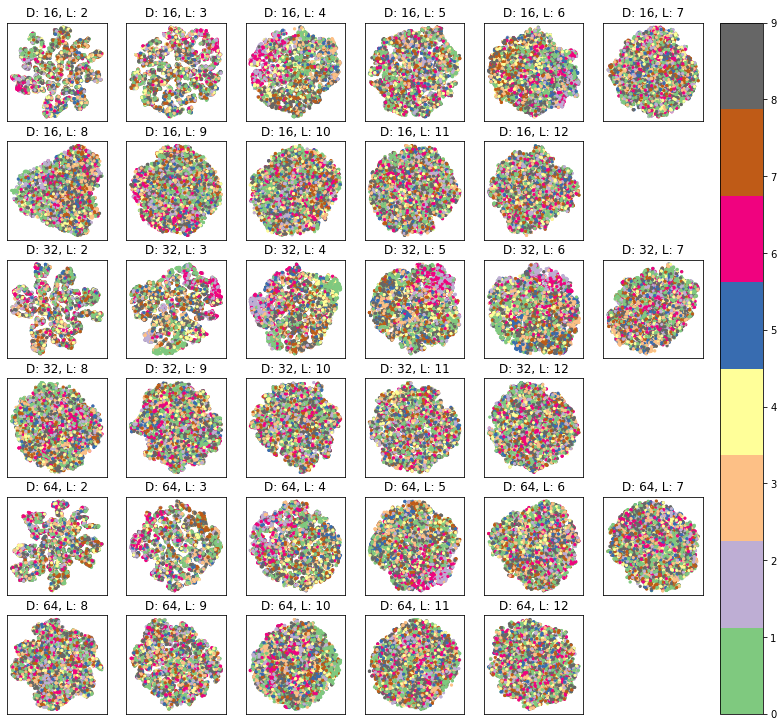

In [11]:
x = next(iter(test_dataset))[0][:5000]
labels = next(iter(test_dataset))[1][:5000]
# 가시화할 데이터셋 생성
encoded_img_list = []
decoded_img_list = []

max_latent_size = 12
for base_depth in [16, 32, 64]:
    for encoded_size in range(2,max_latent_size+1):
        network = VAE(encoded_size, base_depth)
        network.build((1,28, 28, 1))

        checkpoint_name = 'MNIST_VAE_weight/D'+str(base_depth)+"_L"+str(encoded_size)
        network.load_weights(checkpoint_name)
#         network.summary()

        encoded_img_list.append(network.encoder(x))
        decoded_img_list.append(network.decoder(network.encoder(x).sample()))

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

Model_list = [16,32,64]
Latent_list = list(range(2,max_latent_size+1))

k=1
for i, en_list in enumerate(encoded_img_list):
    if (i+k)%12 == 0:
        k+=1
    
    ax = plt.subplot(6, 6, i+k)
    X = TSNE(n_components=2).fit_transform(en_list.sample().numpy())
    plt.scatter(X[:, 0], X[:, 1], s=5, c=labels, cmap=plt.cm.Accent)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text("D: "+str(Model_list[i//len(Latent_list)])+", L: "+str(i%len(Latent_list)+2))
        
plt.subplots_adjust(bottom=0.1, right=0.93, top=0.9)
cax = plt.axes([0.95, 0.1, 0.05, 0.8])
plt.colorbar(cax=cax)
plt.show() 

### 재학습

- z의 분포를 보고 encoder가 label 별로 discriminative한 representation을 만들어내는지 여부를 확인한다. 만일 discriminative하지 않다면, VAE가 discriminative한 representation z를 학습하도록 수정한다.

Base depth(D)가 32 이며, Latent_size 가 4일때의 z의 representation이 같은색의 뭉침 정도가 높은것을 확인할수있다. 따라서 본 모델을 좀더 학습시켜 더 구분이 잘되는 representation z를 학습하도록 한다.

In [12]:
encoded_size = 4
base_depth = 32

network = VAE(encoded_size, base_depth)
network.build((1,28, 28, 1))
checkpoint_name = 'MNIST_VAE_weight/D'+str(base_depth)+"_L"+str(encoded_size)
network.load_weights(checkpoint_name)
network.summary()
recon = lambda x, rv_x: -rv_x.log_prob(x)

network.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                loss=recon)
network.fit(train_dataset,
            epochs=30,
            validation_data=eval_dataset)

Model: "vae_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_132 (Sequential)  (None, 4)                 230622    
_________________________________________________________________
sequential_133 (Sequential)  (None, 28, 28, 1)         320833    
Total params: 551,455
Trainable params: 551,455
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
188/188 [==============================] - 51s 271ms/step - loss: 130.2506 - val_loss: 0.0000e+00
Epoch 2/30
188/188 [==============================] - 44s 232ms/step - loss: 129.9304 - val_loss: 130.6473
Epoch 3/30
188/188 [==============================] - 44s 234ms/step - loss: 129.6403 - val_loss: 130.1544
Epoch 4/30
188/188 [==============================] - 44s 235ms/step - loss: 129.6859 - val_loss: 130.4939
Epoch 5/30
188/188 [==============================] - 44s 235ms/step - loss: 129.6387 

학습 결과 이전보다 결과가 색별로 뭉치는것을 확인할 수 있다.

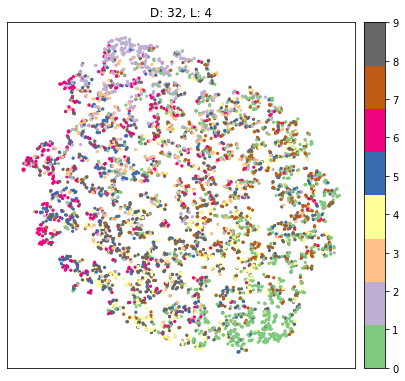

In [13]:
x = next(iter(test_dataset))[0][:5000]
labels = next(iter(test_dataset))[1][:5000]    
encoded_img_list.append(network.encoder(x))
decoded_img_list.append(network.decoder(network.encoder(x).sample()))

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

Model_list = [16,32,64]
Latent_list = list(range(2,max_latent_size+1))

en_list = encoded_img_list[-1]

ax = plt.subplot(1, 1, 1)
X = TSNE(n_components=2).fit_transform(en_list.sample().numpy())
plt.scatter(X[:, 0], X[:, 1], s=5, c=labels, cmap=plt.cm.Accent)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.title.set_text("D: "+str(32)+", L: "+str(4))
        
plt.subplots_adjust(bottom=0.1, right=0.93, top=0.9)
cax = plt.axes([0.95, 0.1, 0.05, 0.8])
plt.colorbar(cax=cax)
plt.show() 

###학습된 VAE에 대해, MNIST 데이터셋의 복원 결과 시각화

- 학습을 마친 VAE의 decoder만으로 generative model을 구성한다. 이 때, p(z)에서 샘플링한 z 값을 decoder으로 주었을 때 손글씨 숫자 이미지가 만들어지는지 확인한다. 의미있게 만들어진 이미지는 어떤 특징을 가지고 있는지 논의한다.

[ 0.0426026   0.18574789 -0.00969844 -0.22468682]


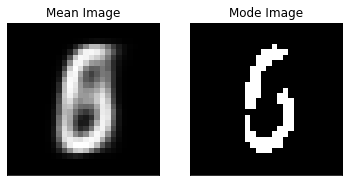

[-0.14201733  0.37762868 -0.15233494 -0.06905893]


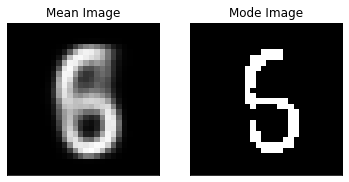

[-0.4660678   0.01779541 -0.04108109 -0.23560208]


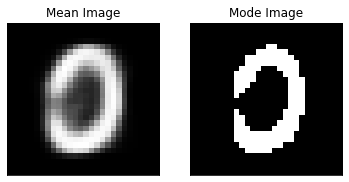

[-0.22600074  0.3798594  -0.27858073  0.20427476]


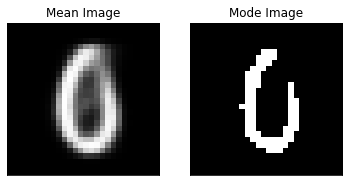

[-0.0428659   0.46111935 -0.51102155 -0.19418405]


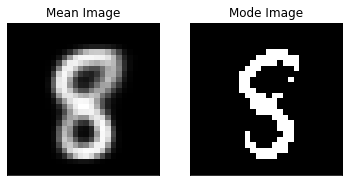

[-0.00604608  0.2993808   0.02103481 -0.6539388 ]


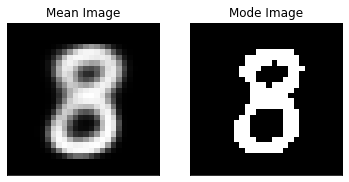

[0.00668411 0.7466725  0.03398883 0.17033122]


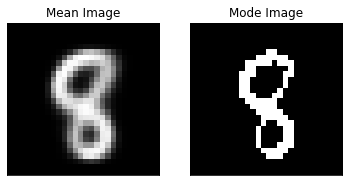

[-0.258512    0.28935358 -0.08096228  0.1793701 ]


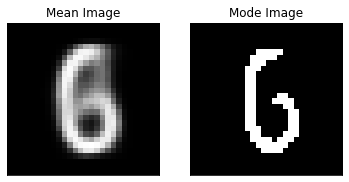

[-0.31275722 -0.01214175  0.02689688  0.23209664]


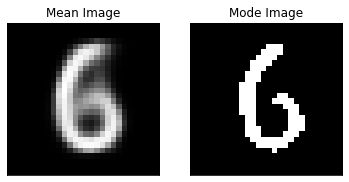

[-0.2042245   0.8023236   0.02520998 -0.49479294]


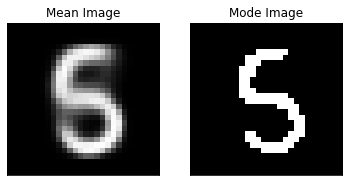

[ 0.00634773  0.37593612 -0.13220099 -0.15685835]


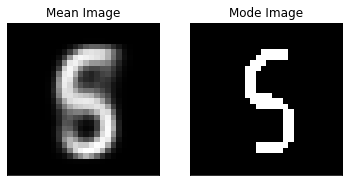

In [14]:
import IPython
import uuid
from google.colab import output
import matplotlib.pyplot as plt
import random


class InvokeButton(object):
    def __init__(self, title, callback):
        self._title = title
        self._callback = callback

    def _repr_html_(self):
        callback_id = 'button-' + str(uuid.uuid4())
        output.register_callback(callback_id, self._callback)

        template = """<button id="{callback_id}">{title}</button>
            <script>
              document.querySelector("#{callback_id}").onclick = (e) => {{
                google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
                e.preventDefault();
              }};
            </script>"""
        html = template.format(title=self._title, callback_id=callback_id)
        return html

def draw_image():

    assert isinstance(decoded_img_list[-1], tfpd.Distribution)

    rand_idx = random.randint(0,labels.shape[0])
    print(encoded_img_list[-1][rand_idx].numpy())
    ax1 = plt.subplot(1, 2, 1)
    plt.imshow(decoded_img_list[-1].mean()[rand_idx].numpy().reshape(28,28), cmap=plt.cm.Greys)
    ax1.title.set_text("Mean Image")
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    ax2 = plt.subplot(1, 2, 2)
    plt.imshow(decoded_img_list[-1].mode()[rand_idx].numpy().reshape(28,28), cmap=plt.cm.Greys)
    ax2.title.set_text("Mode Image")
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    plt.show()

InvokeButton('Generate random number', draw_image)



###학습된 VAE에 대해, 임의의 샘플된 P(z) 값에 대한 복원 실험

3개의 인코딩 값과 출력된 그림을 통하여 볼 때, 

첫번째 인코딩 값은 커지면 7에 가까워지고 작아지면 6에 가까워진다.

두번째 인코딩 값은 숫자의 기울기와 관련이 있다.

세번째 인코딩 값은 음수로 가면 4에 가까워지고 양수로가면 3에 가까워진다.

네번째 인코딩 값은 숫자의 가로길이와 연관되어있다.

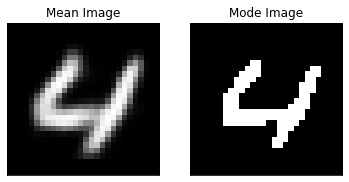

In [65]:
#@title Change z manually {run: 'auto'}

z1 = 0  #@param {type: "slider", min: -5.0, max: 5.0, step: 0.001 }
z2 = 0 #@param {type:"slider", min:-5, max:5, step:0.001}
z3 = -2.567  #@param {type: "slider", min: -5.0, max: 5.0, step: 0.001 }
z4 = 0  #@param {type: "slider", min: -5.0, max: 5.0, step: 0.001 }

z_tensor = tf.constant([[z1, z2, z3, z4]], tf.float32)

decoded_img = network.decoder(z_tensor)

assert isinstance(decoded_img, tfpd.Distribution)

ax1 = plt.subplot(1, 2, 1)
plt.imshow(decoded_img.mean().numpy().reshape(28,28), cmap=plt.cm.Greys)
ax1.title.set_text("Mean Image")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot(1, 2, 2)
plt.imshow(decoded_img.mode().numpy().reshape(28,28), cmap=plt.cm.Greys)
ax2.title.set_text("Mode Image")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.show()
